# Predicting Household Heating Decisions

In [ ]:
# household characteristics cancelling out on top and bottom -> that is why we changed the model to remove them

# options (equivalent): 1. interaction between features/variables 2. make coefficient a function of the other variable
# e.g. divide ic by income

In [1]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

/Users/fahad/miniconda3/envs/BML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
data = pd.read_csv("heating_data.csv")

In [57]:
data.head(5)

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley


In [58]:
len(data)

900

In [59]:
le = LabelEncoder()

In [60]:
labels = ["gc", "gr", "ec", "er", "hp"]

In [61]:
indices = le.fit_transform(labels)
indices

array([2, 3, 0, 1, 4])

In [62]:
data["y"] = le.transform(data["depvar"])

In [63]:
data.head(5)

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region,y
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl,2
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl,2
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl,2
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl,1
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley,1


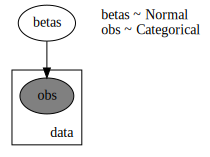

In [88]:
def model(data):
    betas = pyro.sample("betas", dist.Normal(0., 4.).expand([4]))
    V_gc = betas[1] + betas[2] * torch.tensor(data["ic.gc"].values, dtype=torch.float32) + betas[3] * torch.tensor(data["oc.gc"].values, dtype=torch.float32)
    V_gr = betas[1] + betas[2] * torch.tensor(data["ic.gr"].values, dtype=torch.float32) + betas[3] * torch.tensor(data["oc.gr"].values, dtype=torch.float32)
    V_ec = betas[0] + betas[2] * torch.tensor(data["ic.ec"].values, dtype=torch.float32) + betas[3] * torch.tensor(data["oc.ec"].values, dtype=torch.float32)
    V_er = betas[0] + betas[2] * torch.tensor(data["ic.er"].values, dtype=torch.float32) + betas[3] * torch.tensor(data["oc.er"].values, dtype=torch.float32)
    V_hp = betas[2] * torch.tensor(data["ic.hp"].values, dtype=torch.float32) + betas[3] * torch.tensor(data["oc.hp"].values, dtype=torch.float32)
    V = torch.stack([V_gc, V_gr, V_ec, V_er, V_hp], dim=0)[indices].T
    
    y_tensor = torch.tensor(data["y"].values, dtype = torch.int32)

    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Categorical(logits=V), obs=y_tensor)

pyro.render_model(model, model_args=(data,), render_distributions=True)

In [89]:
# MCMC estimation
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [01:09, 17.15it/s, step size=2.99e-02, acc. prob=0.926]


In [95]:
beta_ic_samples = hmc_samples['betas'][:,2]

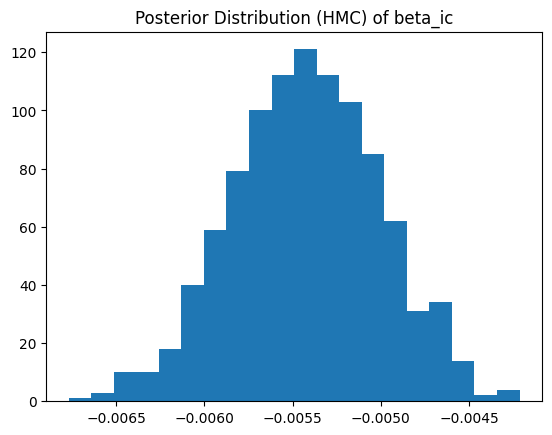

In [100]:
# plot posterior distribution of beta_ic

plt.hist(beta_ic_samples, bins=20)
plt.title("Posterior Distribution (HMC) of beta_ic")
plt.show()

In [103]:
hmc_samples['betas'].mean(axis=0)

array([ 0.7902507 ,  0.6298026 , -0.00541945, -0.00516421], dtype=float32)